# Introduction

The following notebook provides an introduction to the CommonPower framework, its main components, and design philosophy. 

The primary features of CommonPower are 

- an object-oriented approach to modelling power system entities (object layer),

- a Pyomo-based symbolic math representation of entities to obtain all relevant system equations in the background (pyomo layer),

- interfaces for single/multi-agent reinforcement learning and optimal control,

- a flexible interface to make use of diverse data sources and forecasting models.

The most important object classes for modelling a power system in CommonPower:

- **System**: This class is the unique "root" of the power system representation. It keeps a list of all nodes and lines in the system.  

- **Node**: Superclass for busses and components. Can have subordinate child nodes. Can pull the time series of its characteristics from a data source and/or can be controlled.

- **Bus**: Busses come with an internal power balance equation and sum the cost of their children. 

- **Component**: Represents a specific electric device, e.g. battery, PV, gas generator, etc. Cannot have children. 
    Implementing subclasses of components allows for flexible modelling of arbitrary devices.

- **Line**: Represents a power transmission line. Subclasses allow for flexible modelling in conjunction with corresponding power flow models.

- **Power Flow**: This defines how the power flow is modelled on the system level.

In [1]:
import pathlib
from datetime import timedelta
from commonpower.modelling import ModelHistory
from commonpower.core import System
from commonpower.models.components import *
from commonpower.models.busses import *
from commonpower.models.powerflow import *
from commonpower.data_forecasting import *
from commonpower.utils.param_initialization import *
from commonpower.control.runners import DeploymentRunner
from commonpower.control.controllers import OptimalController

## System set-up

We will create a simple test system consisting of one household with a load, battery and PV system.
We assume that the household pays a constant price for energy imports and gets payed a much smaller amount for energy export. 
The optimization task in such a scenario is to dispatch the battery in order to satisfy the household's power demand in the most cost effective way. 
We will use an already implemented "global" optimal controller which could in reality, for example, be run by an energy community manager.

The load and PV components require data providers to read the current power demand and generation, and to obtain a forecast for them.
In order to achieve this, we have included data from the [SimBench](https://simbench.de/de/datensaetze/) in the tutorial folder.
We rename the variable names of the data to match the requirements of the load and PV component in our project.

In [2]:
control_sample_time = timedelta(hours=1)
forecast_frequency = timedelta(hours=1)
forecast_horizon = timedelta(days=2)
control_horizon = timedelta(days=1)

In [3]:
# path to data profiles
current_path = pathlib.Path().absolute()
data_path = current_path / 'data'
data_path = data_path.resolve()

load_data = CSVDataSource(data_path / '1-LV-rural2--1-sw' / 'LoadProfile.csv',
            delimiter=";", 
            datetime_format="%d.%m.%Y %H:%M", 
            rename_dict={"time": "t", "H0-A_pload": "p", "H0-A_qload": "q"},
            auto_drop=True, 
            resample=forecast_frequency
).apply_to_column("p", lambda x: 10*x).apply_to_column("q", lambda x: 0.0)

pv_data = CSVDataSource(data_path / '1-LV-rural2--1-sw' / 'RESProfile.csv', 
        delimiter=";", 
        datetime_format="%d.%m.%Y %H:%M", 
        rename_dict={"time": "t", "PV3": "p"},
        auto_drop=True, 
        resample=forecast_frequency
).apply_to_column("p", lambda x: -10*x)

price_data = ConstantDataSource({
    "psis": 0.08,  # the household gets payed 0.08 price units for each kWh exported to the external grid
    "psib": 0.34  # the houshold pays 0.34 price units for each imported kWh
    }, 
    date_range=load_data.get_date_range(), 
    frequency=forecast_frequency
)

A data provider is always defined by a datasource and a forecaster providing observations over the forecast horizon.

In [4]:
load_data_provider = DataProvider(load_data, PerfectKnowledgeForecaster(frequency=forecast_frequency, horizon=forecast_horizon))
pv_data_provider = DataProvider(pv_data, PerfectKnowledgeForecaster(frequency=forecast_frequency, horizon=forecast_horizon))
price_data_provider = DataProvider(price_data, PerfectKnowledgeForecaster(frequency=forecast_frequency, horizon=forecast_horizon))

CommonPower's modelling layers (object and pyomo) are built-up as tree stuctures.
On the object layer the root node is always a singleton instance of the `System` class. 
The system then contains an arbitrary number of "top-level" nodes (busses) and lines connecting them. Since power flow calculations are only considered on this top-level, we call this the "power flow level".
Each node can then have subordinate busses or components connected to it.
Nodes' active/reactive power is calculated as the sum of their associated subordinate nodes'/components' power. 
Voltage angle and magnitude are only relevant on the power flow level and enforced for all children of top-level nodes.

**We will model our use case as a single bus system consisting of one household and a connection to the external grid. We do, therefore, not need to define any lines.**

When instantiating model entities (e.g. nodes, components) you have to pass them a configuration dict which specifies ranges/values for their model elements (variables/parameters).
You can determine which configurations are needed by calling the info() method or simply trying an empty dict (commonpower will then let you know if it misses something).


In [5]:
# ESS = Energy Storage System
ESS.info()


---- INFO: ESS ----

+----------+----------+------------------------------------------+------------------+------------+------------------------------+---------------+
| Element  |   Type   |               Description                |      Domain      |   Bounds   |       Required config        | Data provider |
+----------+----------+------------------------------------------+------------------+------------+------------------------------+---------------+
|    p     |  INPUT   |               active power               |      Reals       |    None    |           (lb, ub)           |               |
|    q     |   VAR    |              reactive power              |      Reals       |    None    |           (lb, ub)           |               |
|   soc    |  STATE   |        state of charge (absolute)        | NonNegativeReals |    None    |           (lb, ub)           |               |
|   rho    | CONSTANT |             cost of wear pu              | NonNegativeReals |    None    | con

In [6]:
# RT = Real Time
household = RTPricedBus("Household").add_data_provider(price_data_provider)
    
# components
capacity = 10  #kWh
ess = ESS("ESS", {
    'rho': 0.001,  # charging/discharging 1 kWh incurs a cost of wear of 0.001
    'p': (-2, 2),  # active power limits
    'q': (0, 0),  # reactive power limits
    'etac': 0.98,  # charging efficiency
    'etad': 0.98,  # discharging efficiency
    'etas': 0.99,  # self-discharge (after one time step 99% of the soc is left)
    'soc': (0.1 * capacity, 0.9 * capacity),  # soc limits
    "soc_init": ConstantInitializer(0.2 * capacity)  # initial soc at the start of simulation
})

# load with data source
load = Load("Load").add_data_provider(load_data_provider)

# pv generator
pv = RenewableGen("PV").add_data_provider(pv_data_provider)

# external grid connection
ext_grid = ExternalGrid("ExternalGrid")

# we first have to add the nodes to the system 
# and then add components to the nodes in order to obtain a tree-like structure
sys = System(power_flow_model=PowerBalanceModel()).add_node(household).add_node(ext_grid)

# add components to household
household.add_node(load).add_node(ess).add_node(pv)

# show system structure: 
sys.pprint()


SYSTEM OVERVIEW 
 
Nodes: 
    (RTPricedBus): Household  
       (Load): Load  
       (ESS): ESS  
       (RenewableGen): PV  
    (ExternalGrid): ExternalGrid  

Lines: 



## Running one day

The most straight-forward control scenario is a single OptimalController which controls all controllable variables in the system.
We run it for one single day.

In [ ]:
sys_history = ModelHistory([sys])
runner = DeploymentRunner(sys=sys, history=sys_history, forecast_horizon=forecast_horizon, control_horizon=control_horizon, dt=control_sample_time)
runner.run(24, fixed_start = "27.07.2016")

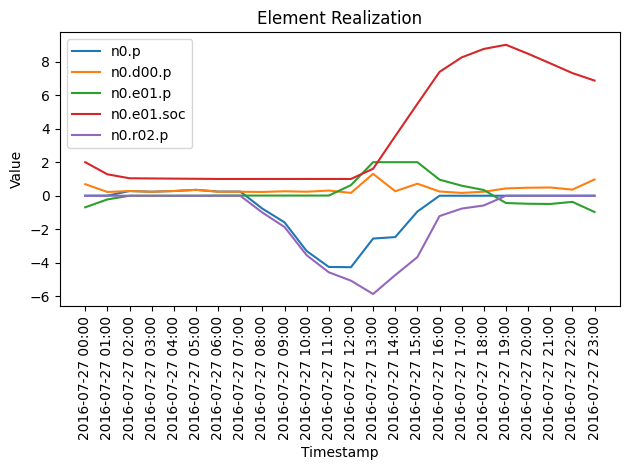

In [8]:
# plot what the household components are doing
sys_history.filter_for_entities(household, True).filter_for_element_names(["p", "soc"]).plot()

# explanation for the plot:
# d - load, e - ess, r - renewable energy generator

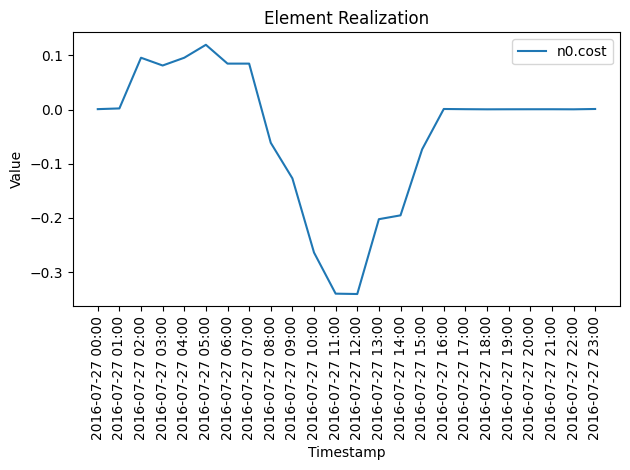

In [9]:
# plot the household cost
sys_history.filter_for_entities(household).filter_for_element_names(["cost"]).plot()

We can see quity nicely how the controller first exports the PV generation and then uses it to charge up the battery for future use.
As a first small study, you could investigate how this behavior adapts if you change the ESS parameters.